Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk

all_stream_data = load_from_disk("data/processed/all_stream_data")


In [2]:
print(all_stream_data)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 72342
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1925
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1926
    })
})


In [10]:
from transformers import AutoTokenizer
import torch

model_id = "microsoft/MiniLM-L12-H384-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512, return_tensors="pt")


In [11]:
train_dataset = all_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = all_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/72342 [00:00<?, ? examples/s]

Map:   0%|          | 0/1925 [00:00<?, ? examples/s]

In [12]:
labels = all_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [13]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


In [15]:
# from huggingface_hub import notebook_login
# notebook_login()


In [14]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 64
num_train_epochs = 4
learning_rate = 2e-5
logging_steps = len(train_dataset) // batch_size
model_name = f"./models/{model_id}-finetuned-arxiv-test"
training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size * 2,
                                  weight_decay=0.01,
                                  warmup_steps=500,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  save_strategy="steps",
                                  save_total_limit=3,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=True,
                                  label_smoothing_factor=0.1,
                                  log_level="error")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [16]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
500,No log,2.169775,0.231017,0.285778
1000,No log,1.690605,0.382707,0.500948
1500,2.159700,1.318529,0.483869,0.619730
2000,2.159700,1.145184,0.553885,0.674817
2500,1.262600,1.014943,0.569291,0.708252
3000,1.262600,0.956274,0.574010,0.697666
3500,0.948700,0.959664,0.571257,0.701146
4000,0.948700,0.978186,0.571326,0.678515
4500,0.948700,0.933624,0.575351,0.694969


TrainOutput(global_step=4524, training_loss=1.2933156798098806, metrics={'train_runtime': 1281.7801, 'train_samples_per_second': 225.755, 'train_steps_per_second': 3.529, 'total_flos': 1.9066251545542656e+16, 'train_loss': 1.2933156798098806, 'epoch': 4.0})

In [25]:
preds_output = trainer.predict(eval_dataset)


In [26]:
preds_output.metrics


{'test_loss': 0.7977012991905212,
 'test_macro_f1': 0.6629790667793978,
 'test_balanced_accuracy': 0.7556766833481143,
 'test_runtime': 3.0468,
 'test_samples_per_second': 631.82,
 'test_steps_per_second': 5.251}

In [27]:
y_preds = np.argmax(preds_output.predictions, axis=1)


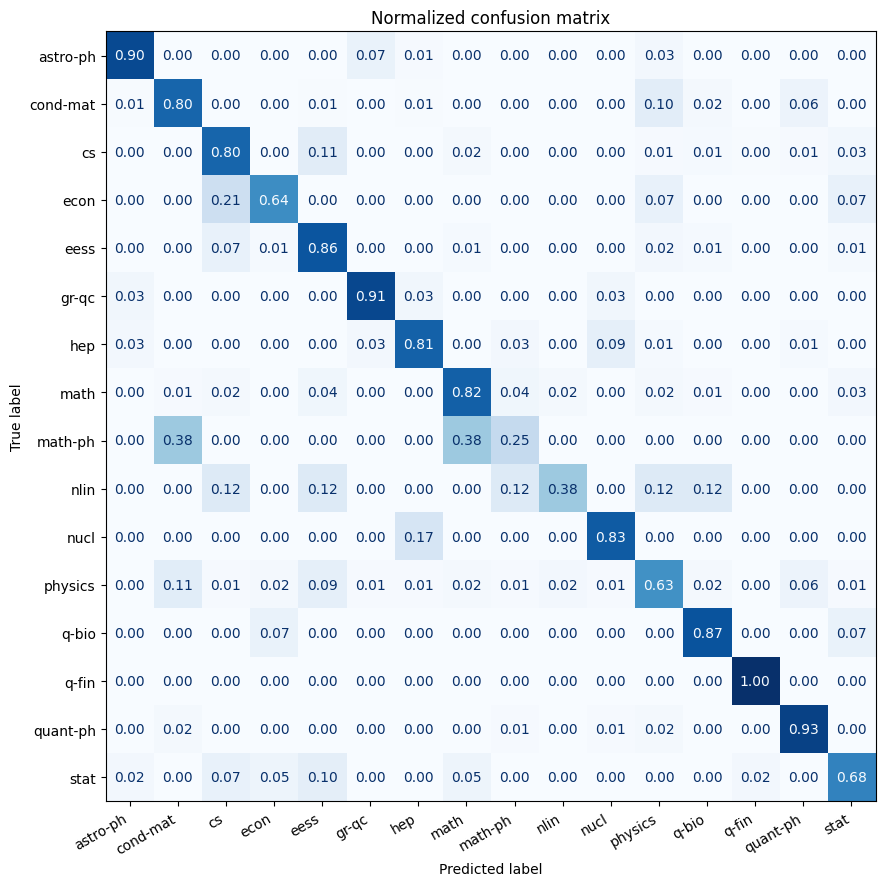

In [28]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.95      0.90      0.92       120
    cond-mat       0.83      0.80      0.81       137
          cs       0.97      0.80      0.87       818
        econ       0.47      0.64      0.55        14
        eess       0.38      0.86      0.52        84
       gr-qc       0.72      0.91      0.81        32
         hep       0.90      0.81      0.85        79
        math       0.92      0.82      0.86       331
     math-ph       0.11      0.25      0.15         8
        nlin       0.25      0.38      0.30         8
        nucl       0.60      0.83      0.70        18
     physics       0.66      0.63      0.64       123
       q-bio       0.39      0.87      0.54        15
       q-fin       0.54      1.00      0.70         7
    quant-ph       0.78      0.93      0.85        90
        stat       0.43      0.68      0.53        41

    accuracy                           0.80      1925
   macro avg       0.62   

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)
